# MobileNetV3 YOLOv3 for Text Detection

A text detection model based on MobileNetV3 and YOLOv3.<br>
Pruned and quantized for deployment on edge devices.

- [x] Pretrained MobileNetV2 backbone
- [x] YOLOv3 top end
- [x] Basic Pruning, Quantization integration
- [x] Training pipeline (for ICDAR 2015)
- [x] Switch backbone to MobileNetV3
- [x] Mixed Precision Training
- [x] Advanced Pruning and quantization

- [ ] Basic Inference
- [ ] Performance Evaluation
- [ ] Deflate Jupyter Notebook into file structure
- [ ] Advanced training pipeline (COCO-Text dataset, batch augmentation, etc.)
- [ ] Live Image-Feed Inference

In [1]:
!pip install torch-optimizer

In [2]:
import gc
import os
import csv
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_optimizer as optim
import torchvision.models as models
import matplotlib.patches as patches
import torch.nn.utils.prune as prune

from PIL import Image
from pathlib import Path
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

%matplotlib inline

---

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using training device: {device}")

batch_size = 32
num_workers = 4
num_classes = 1
learning_rate = 2e-4
num_epochs = 25
warmup_epochs = 10
weight_decay = 1e-4
swa_kickoff = 0.6
optim_k = 5
optim_alpha = 0.5
warmup_start = 0.3
scheduler_t0 = 2
scheduler_tmult = 2
swa_lr = 1e-3
swa_anneal_sched = 5
prune_amount = 0.3
smoothing_factor = 0.05
target_architecture = 'cuda'
dropout_rate = 0.1
max_dropout_rate = 0.4

# https://www.kaggle.com/datasets/bestofbests9/icdar2015
dataset_path = Path("/kaggle/input/icdar2015")
train_path = dataset_path / 'ch4_training_images'
train_labels = dataset_path / 'ch4_training_localization_transcription_gt'
test_path = dataset_path / 'ch4_test_images'
test_labels = dataset_path / 'ch4_test_localization_transcription_gt'

model_path = 'pq_yolov3_mobilenetv3.pth'

Using training device: cuda


---

## Model Definition

In [4]:
class MobileYOLOv3(nn.Module):
    """
    In:  (batch_size, 3, 448, 224)
    Out: (batch_size, 7, 4, num_anchors * (5 + num_classes))
          5 + num_classes = 4 (x,y,w,h) 
                            + 1 (objectness) 
                            + num_classes (class probabilities)
    Making for 7x4=28 grid tiles with num_anchors many (5 + num_classes) values each.
    YoloV3 originally starts 13x13, but I deviate for a smaller model.
    """

    def __init__(self, num_classes=1, num_anchors=3):
        super(MobileYOLOv3, self).__init__()
        self.num_classes = num_classes  # 1, but keep this flexible
        self.num_anchors = num_anchors  # 3, like the original YOLOv3
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1)
        self.mobilenet = models.mobilenet_v3_small(weights='IMAGENET1K_V1').features
        self.residual_conv = nn.Conv2d(3, 576, kernel_size=3, stride=32, padding=1)
        self.dropout = nn.Dropout(max_dropout_rate)
        self.conv2 = nn.Conv2d(576, num_anchors * (5 + num_classes), kernel_size=1, stride=1, padding=0)

    def forward(self, x):           # Input shape: (batch_size, 3, 448, 224)
        r = F.relu(self.conv1(x))   # (batch_size, 3, 224, 112)
        x = self.mobilenet(r)       # (batch_size, 576, 7, 4)
        x = self.dropout(x)         # same
        x = F.relu(self.conv2(x + F.relu(self.residual_conv(r)))) # (batch_size, num_anchors * (5 + num_classes), 7, 4)
        return x.permute(0, 2, 3, 1).contiguous() # (batch_size, 7, 4, num_anchors * (5 + num_classes))

---

## Pruning & Quantization Definition

In [5]:
def prune_model(model, amount=0.25):
    """
    Weed out amount percentage of weakest model connections.
    """
    for _, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
            if module.bias is not None:
                prune.l1_unstructured(module, name='bias', amount=amount/2)
                prune.remove(module, 'bias')
    parameters_to_prune = [(module, 'weight') for module in model.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount/2)
    return model

def quantize_model(model, device):
    """
    Reduce numeric precision of weights and activations.
    """
    model = model.cpu() # Quantization happens ONLY ever on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True  # inplace=True avoids deepcopy errors
    )
    return quantized_model.to(device)

---

## Dataset

In [6]:
class ICDAR2015(Dataset):
    """
    ICDAR2015 Dataset for YOLOv3 training.
    Required Inputs: input_path, label_path,
    Output: (batch_size, 3, 448, 224), (batch_size, 7, 4, num_anchors * (5 + num_classes))
    (5 = 4 (x,y,w,h) + 1 (objectness) + num_classes (class probabilities))
    """
    def __init__(self, input_path, label_path, num_classes=1, num_anchors=3, transform=(448, 224), grid_size=(7, 4), img_format='.jpg'):
        self.input_path = Path(input_path)  # Path to images
        self.label_path = Path(label_path)  # Path to labels
        self.num_classes = num_classes      # Number of associable classes
        self.num_anchors = num_anchors      # Number of predictable distinct objects per grid tile
        self.image_size = transform         # Image size
        self.grid_size = grid_size          # Grid size
        self.batch_count = 0                # Counter for sequential batch generation
        self.transform = transforms.Compose([
            transforms.Resize(transform),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.ToTensor()
        ]) # Encounter same image multiple times, different augmentations each time
        self.files = self._assemble_files(img_format)
        self.labels = [self._parse_label(label, Image.open(img).size) for img, label in self.files]

    def _assemble_files(self, img_format):
        image_files = list(self.input_path.glob(f'*{img_format}'))
        data = []
        for img_file in image_files:
            img_id = img_file.stem.split('_')[-1]
            label_file = self.label_path / f"gt_img_{img_id}.txt"
            if label_file.exists():
                data.append((img_file, label_file))
            else:
                print(f"Warning: No matching label file found for {img_file.name}")
        return data

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path, _ = self.files[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        label = self.labels[idx]
        return img, label
    
    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self):
            raise StopIteration
        item = self[self.index]
        self.index += 1
        return item
    
    def _parse_label(self, label_path, img_size):
        labels = torch.zeros((self.grid_size[0], self.grid_size[1], self.num_anchors * (5 + self.num_classes)))
        with open(label_path, 'r', encoding='utf-8-sig') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                row = torch.tensor([float(i) for i in row[:8]])
                x, y = (row[0::2].sum() / 4, row[1::2].sum() / 4)
                w = row[0::2].max() - row[0::2].min()
                h = row[1::2].max() - row[1::2].min()
                
                x = min(x, img_size[0] - 1e-3)
                y = min(y, img_size[1] - 1e-3)
                w = min(w, img_size[0] - 1e-3)
                h = min(h, img_size[1] - 1e-3)

                x, y = x / img_size[0] * self.grid_size[0], y / img_size[1] * self.grid_size[1]
                
                grid_x, grid_y = min(max(int(x), 0), self.grid_size[0] - 1), min(max(int(y), 0), self.grid_size[1] - 1)
                x, y = x - grid_x, y - grid_y
                
                w, h = w / img_size[0], h / img_size[1]

                obj = 1.0   # Objectness
                # We can leave the Class Probabilities at 0 for now, objectness is enough if just one class exists
                cls = 0.0 if self.num_classes == 1 else torch.zeros(self.num_classes)

                # 4 (x,y,w,h) + 1 (objectness) + num_classes (class probabilities)
                box = torch.tensor([x, y, w, h, obj, cls] if self.num_classes == 1 else [x, y, w, h, obj] + cls.tolist())
                center_distance = torch.sqrt((box[2] - 0.5)**2 + (box[3] - 0.5)**2).item()
                
                for anchor in range(self.num_anchors):
                    anchor_slice = slice(anchor * (5 + self.num_classes), (anchor + 1) * (5 + self.num_classes))
                    if labels[grid_x, grid_y, anchor_slice].sum() == 0:
                        labels[grid_x, grid_y, anchor_slice] = box
                        break
                    elif labels[grid_x, grid_y, anchor * (5 + self.num_classes) + 4] == 1.0:
                        c_box = labels[grid_x, grid_y, anchor_slice]
                        c_distance = torch.sqrt((c_box[2] - 0.5)**2 + (c_box[3] - 0.5)**2).item()
                        if center_distance < c_distance:
                            labels[grid_x, grid_y, anchor_slice] = box
                            break
        return labels

    def next_batch(self, batch_size, randomized=True):
        if randomized:
            indices = np.random.choice(len(self), batch_size, replace=False)
        else:
            indices = np.arange(self.batch_count, self.batch_count + batch_size) % len(self)
            self.batch_count += batch_size
        
        batch_images = torch.stack([self[i][0] for i in indices], dim=0) # Images
        batch_labels = torch.stack([self.labels[i] for i in indices], dim=0) # Labels
        # (batch_size, 3, 448, 224), (batch_size, 7, 4, num_anchors * (5 + num_classes))
        return batch_images, batch_labels

    @staticmethod
    def collate_fn(batch):
        images, labels = zip(*batch)
        images = torch.stack(images, dim=0)
        labels = torch.stack(labels, dim=0)
        # (batch_size, 3, 448, 224), (batch_size, 7, 4, num_anchors * (5 + num_classes))
        return images, labels

---

## Loss

In [7]:
class YoLoss(nn.Module):
    """
    Custom YOLOv3-based loss function.
    Returns a scalar loss value, normalized over batch size, based on:
    - Coordinate loss for boxes with IoU > threshold and IoU < threshold
    - Objectness loss
    - No-objectness loss
    - Class loss (only for objects)
    """
    def __init__(self, num_classes=1, num_anchors=3, lambda_coord=5, lambda_noobj=0.5, 
                 lambda_class=1, iou_threshold=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes      # Expecting this many different classes
        self.num_anchors = num_anchors      # Amount of boxes each grid cell is capable of predicting
        self.lambda_coord = lambda_coord    # Penalty factor, coordinate misalignment
        self.lambda_noobj = lambda_noobj    # Penalty factor, objectness misidentification
        self.lambda_class = lambda_class    # Penalty factor, class misattribution
        self.iou_threshold = iou_threshold  # If IoU > threshold -> objectness = 1 -> Spacial box attribution guide
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma

    def focal_loss(self, pred, target, alpha, gamma):
        BCE_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        return alpha * (1 - pt) ** gamma * BCE_loss
        
    def forward(self, predictions, targets):
        """
        predictions, targets: (batch_size, grid_size_x, grid_size_y, num_anchors * (5 + num_classes))
        out -> scalar loss value
        """
        batch_size, grid_size_x, grid_size_y, _ = predictions.size()

        # Mend to (batch_size, grid_size_x, grid_size_y, num_anchors, 5 + num_classes)
        # Thankfully this stripes the tensor into the desired shape (num_anchors many breaks in the last dimension)
        predictions = predictions.view(batch_size, grid_size_x, grid_size_y, self.num_anchors, 5 + self.num_classes)
        targets = targets.view(batch_size, grid_size_x, grid_size_y, self.num_anchors, 5 + self.num_classes)

        # Split into components
        p_xy = predictions[..., :2]
        p_wh = predictions[..., 2:4]
        p_obj = predictions[..., 4]
        p_class = predictions[..., 5:]  # Predicted class probabilities (if applicable)

        t_xy = targets[..., :2]
        t_wh = targets[..., 2:4]
        t_obj = targets[..., 4]
        t_class = targets[..., 5:]  # Target class probabilities

        # Coordinate Loss for cells containing an object
        coord_loss = self.lambda_coord * t_obj * (
            F.mse_loss(p_xy, t_xy, reduction='none').sum(-1) + 
            F.mse_loss(p_wh, t_wh, reduction='none').sum(-1)
        )
        
        # Penalize incorrect objectness predictions
        obj_loss = self.focal_loss(p_obj, t_obj, self.focal_alpha, self.focal_gamma)

        # Penalize incorrect non-objectness predictions
        no_obj_loss = self.lambda_noobj * (1 - t_obj) * obj_loss

        # 4. Class Loss with Focal Loss (if applicable)
        if self.num_classes > 1:
            # Penalize incorrect class predictions
            class_loss = self.lambda_class * t_obj * self.focal_loss(p_class, t_class, self.focal_alpha, self.focal_gamma).sum(-1)
        else:
            # No class-related loss if only one class
            class_loss = torch.zeros_like(coord_loss)

        # Total loss: sum of all components, divided by batch size
        total_loss = (coord_loss + obj_loss + no_obj_loss + class_loss).sum() / batch_size

        return total_loss

---

## Training

In [8]:
train_dataset = ICDAR2015(train_path, train_labels, num_classes)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                           pin_memory=True)

val_dataset = ICDAR2015(test_path, test_labels, num_classes)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, collate_fn=ICDAR2015.collate_fn,
                         pin_memory=True)

def evaluate(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=str(device)):
                outputs = model(images)
                loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def adaptive_gradient_clipping(model, clip_factor=0.01, eps=1e-3):
    for param in model.parameters():
        param_norm = torch.norm(param.grad)
        clip_value = clip_factor * (torch.norm(param) + eps)
        param.grad = param.grad * (clip_value / (param_norm + eps))

In [9]:
model = MobileYOLOv3(num_classes=num_classes).to(device)
criterion = YoLoss()

# Adam, but decoupling weight decay from the gradient update
base_optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Periodically look ahead, update weights by averaging weight updates at every k steps
optimizer = optim.Lookahead(base_optimizer, k=optim_k, alpha=optim_alpha)

# Increase learning rate gradually, prevent harsh updates early on
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_start, total_iters=warmup_epochs)

# Periodically run original learning rate, decaying it following a cosine curve over T_0 epochs
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=scheduler_t0, T_mult=scheduler_tmult)

# Avoids numerical underflow/overflow through scaling, helps maintain information in mixed-precision
scaler = torch.amp.GradScaler(enabled=(str(device) != 'cpu'))

# Running model param average, stabilizes training
swa_model = AveragedModel(model)

# Learning rate scheduler for SWA phase
swa_scheduler = SWALR(optimizer, swa_lr=swa_lr, anneal_strategy="cos", anneal_epochs=swa_anneal_sched)

In [10]:
lossi, losst = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    model.dropout.p = max_dropout_rate + (dropout_rate - max_dropout_rate) * (epoch / num_epochs)
    
    for files, targets in train_loader:
        files = files.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type=str(device)):
            outputs = model(files)
            smoothed_targets = (1 - smoothing_factor) * targets + smoothing_factor / num_classes
            loss = criterion(outputs, smoothed_targets)

        scaler.scale(loss).backward()
        adaptive_gradient_clipping(model)
        
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader)
    lossi.append(epoch_loss)
    
    t_loss = evaluate(model, criterion, val_loader, device)
    losst.append(t_loss)

    # SWA starts averaging model weights
    if epoch > num_epochs * swa_kickoff:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
        
    # GPUs are expensive
    gc.collect()
    torch.cuda.empty_cache()

    # Print training and test loss
    print(f'Epoch [{epoch+1:3}/{num_epochs}] | Train: {epoch_loss:8.3f} | Test: {t_loss:8.3f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch [  1/25] | Train:   83.295 | Test:   28.287 | LR: 0.000100
Epoch [  2/25] | Train:   42.293 | Test:   28.267 | LR: 0.000200
Epoch [  3/25] | Train:   34.237 | Test:   27.878 | LR: 0.000171
Epoch [  4/25] | Train:   30.960 | Test:   26.271 | LR: 0.000100
Epoch [  5/25] | Train:   28.652 | Test:   24.882 | LR: 0.000029
Epoch [  6/25] | Train:   27.537 | Test:   23.842 | LR: 0.000200
Epoch [  7/25] | Train:   25.797 | Test:   19.784 | LR: 0.000192
Epoch [  8/25] | Train:   23.144 | Test:   17.583 | LR: 0.000171
Epoch [  9/25] | Train:   21.275 | Test:   15.901 | LR: 0.000138
Epoch [ 10/25] | Train:   20.216 | Test:   15.254 | LR: 0.000100
Epoch [ 11/25] | Train:   19.438 | Test:   14.873 | LR: 0.000062
Epoch [ 12/25] | Train:   19.128 | Test:   14.693 | LR: 0.000029
Epoch [ 13/25] | Train:   18.837 | Test:   14.714 | LR: 0.000008
Epoch [ 14/25] | Train:   18.743 | Test:   14.603 | LR: 0.000200
Epoch [ 15/25] | Train:   18.571 | Test:   14.354 | LR: 0.000198
Epoch [ 16/25] | Train:  

In [11]:
# Use the 'swa_model' from here on
torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)

# Prune, Quantize
pruned_model = prune_model(swa_model, amount=prune_amount)
quantized_model = quantize_model(pruned_model, device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

---

## Evaluate

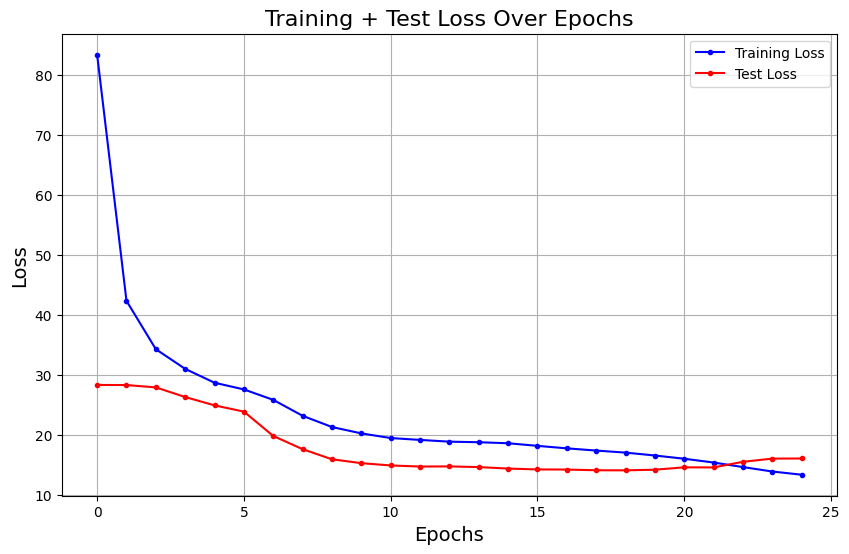

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=3)
plt.plot(range(num_epochs), losst, label="Test Loss", color="red", marker='o', linestyle='-', markersize=3)

plt.title('Training + Test Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right')
plt.show();

In [20]:
def load_model(model_class, num_classes, model_path, target_device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if isinstance(target_device, str):
        target_device = torch.device(target_device)

    # Load to CPU first
    state_dict = torch.load(model_path, map_location=target_device, weights_only=False)
    
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove 'module.' prefix caused by SWA
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
        
    model = model_class(num_classes)
    model.load_state_dict(new_state_dict, strict=False)
    model = model.to(target_device)
    model.eval()
    return model

In [14]:
def yolo_to_icdar2015(predictions, original_sizes, conf_threshold=0.5, num_anchors=3):
    batch_size, grid_h, grid_w, _ = predictions.shape
    predictions = predictions.view(batch_size, grid_h, grid_w, num_anchors, -1)
    
    bboxes_per_image = []

    for img_idx in range(batch_size):
        boxes = []
        orig_w, orig_h = original_sizes[img_idx]

        for y in range(grid_h):
            for x in range(grid_w):
                for anchor in range(num_anchors):
                    pred = predictions[img_idx, y, x, anchor]
                    obj_conf = pred[4].sigmoid()
                    if obj_conf > conf_threshold:
                        cx, cy, w, h = pred[:4].sigmoid()
                        
                        # Convert to absolute coordinates
                        cx_abs = (x + cx) / grid_w * orig_w
                        cy_abs = (y + cy) / grid_h * orig_h
                        w_abs = w * orig_w
                        h_abs = h * orig_h

                        # Calculate corner coordinates
                        x_min = cx_abs - w_abs / 2
                        y_min = cy_abs - h_abs / 2
                        x_max = cx_abs + w_abs / 2
                        y_max = cy_abs + h_abs / 2

                        # Convert to four-point bounding box
                        box = [
                            x_min, y_min,  # Top-left
                            x_max, y_min,  # Top-right
                            x_max, y_max,  # Bottom-right
                            x_min, y_max   # Bottom-left
                        ]
                        boxes.append(box)
        
        bboxes_per_image.append(boxes)
    return bboxes_per_image

In [15]:
def process_batch(model, dataset, device, num_images=10, conf_threshold=0.5):
    model.eval()
    sampled_indices = random.sample(range(len(dataset)), num_images)
    original_imgs, original_sizes, batch_imgs = [], [], []

    for idx in sampled_indices:
        img, _ = dataset[idx]
        original_size = (img.shape[2], img.shape[1])  # (width, height)
        original_imgs.append(img.permute(1, 2, 0).cpu().numpy())  # Store as HWC numpy array
        original_sizes.append(original_size)
        batch_imgs.append(img)

    batch_tensor = torch.stack(batch_imgs).to(device)

    with torch.no_grad():
        predictions = model(batch_tensor)

    return yolo_to_icdar2015(predictions, original_sizes, conf_threshold), original_imgs

In [16]:
def visualize_predictions(model, dataset, device, num_images=10, conf_threshold=0.5):
    predicted_boxes, original_images = process_batch(model, dataset, device, num_images, conf_threshold)

    for img_idx in range(num_images):
        img = original_images[img_idx]
        img_disp = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display

        fig, ax = plt.subplots(1)
        ax.imshow(img_disp)
        boxes = predicted_boxes[img_idx]
        
        for box in boxes:
            x1, y1, x2, y2, x3, y3, x4, y4 = box
            rect = patches.Rectangle((x1, y1), x3 - x1, y3 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        plt.axis('off')  # Hide axes
        plt.show()

In [21]:
model = load_model(MobileYOLOv3, num_classes, model_path, 'cpu')

dataset = ICDAR2015(train_path, train_labels)
visualize_predictions(model, dataset, 'cpu', num_images=10, conf_threshold=0.6) # Still horrible

RuntimeError: shape '[10, 5, -1, 4, 18]' is invalid for input of size 5040